In [1]:
import sys
sys.path.insert(0, '../')

import torch
from functions import CustomSampler, load_pretrained_mlp, load_pretrained_cae, get_model_predictions, average_fusion_predictions, calculate_classification_report, calculate_fusion_accuracy
from ae_functions import get_latent_dataloader
from ae_models import improvedCAE, simpleCAE
from mlp_functions import train_mlp, validate_mlp, decision_level_fusion
from mlp_models import improvedMLP, simpleMLP
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [11]:
BATCH_SIZE = 8

DEVICE = ""
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
OBJECTS = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk', '12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher', '16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/fusion'

sensor_color = "color"
sensor_left = "icub_left"
sensor_right = "icub_right"
sensor_depth = "depthcolormap"

# Load CAE models
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights_ae/"
cae_color = load_pretrained_cae(simpleCAE, model_path, "improved/improved_cae_ne3_b8_color.pth", DEVICE)
cae_left = load_pretrained_cae(simpleCAE, model_path, "improved/improved_cae_ne3_b8_icub_left.pth", DEVICE)
cae_right = load_pretrained_cae(simpleCAE, model_path, "improved/improved_cae_ne3_b8_icub_right.pth", DEVICE)
#cae_depth = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_depth.pth", DEVICE)

# Load CAE models Improved
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights_ae/"
cae_color = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_color.pth", DEVICE)
cae_left = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_icub_left.pth", DEVICE)
cae_right = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_icub_right.pth", DEVICE)
#cae_depth = load_pretrained_cae(improvedCAE, model_path, "improved/improved_cae_ne3_b8_depth.pth", DEVICE)

# Assuming the datasets for all sensors are the same size
dataset_size = 640  # Replace with the actual size of your dataset
shuffled_indices = torch.randperm(dataset_size).tolist()

# Get dataloaders
set_name = "testing"
test_loader_color, size = get_latent_dataloader(cae_color, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_color, set_name, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_left, size = get_latent_dataloader(cae_left, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_left, set_name, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)
test_loader_right, size = get_latent_dataloader(cae_right, BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, sensor_right, set_name, shuffle=False, batch_size=BATCH_SIZE, device=DEVICE, indices=shuffled_indices)

dataloaders = [test_loader_color, test_loader_left, test_loader_right]

##### CONFIG
output_dim = 4
input_dim = size

# Load MLP models
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights_mlp/"
mlp_color = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_improved_cae_ne3_b8_color_action.pth", DEVICE, input_dim, output_dim)
mlp_left = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_improved_cae_ne3_b8_icub_left_action.pth", DEVICE, input_dim, output_dim)
mlp_right = load_pretrained_mlp(improvedMLP, model_path, "simple/improved_mlp_improved_cae_ne3_b8_icub_right_action.pth", DEVICE, input_dim, output_dim)

models = [mlp_color, mlp_left, mlp_right]

# Get predictions
model_predictions = [get_model_predictions(model, dataloader, DEVICE) for model, dataloader in zip(models, dataloaders)]

# Combine and average predictions
final_predictions = average_fusion_predictions(model_predictions)

# Convert to predicted classes
predicted_classes = [pred.argmax(dim=-1) for pred in final_predictions]
predicted_classes_list = [pred.cpu().numpy() if torch.is_tensor(pred) else pred for pred in predicted_classes]

# Gather true labels and calculate accuracy
class_names = ['left_to_right', 'pull', 'push', 'right_to_left']
true_labels = [labels.cpu().numpy() for _, labels in test_loader_color]

accuracy = calculate_fusion_accuracy(predicted_classes_list, true_labels)
calculate_classification_report(predicted_classes_list, true_labels, class_names)

print(accuracy)

CUDA is available. Using GPU...
               precision    recall  f1-score   support

left_to_right       0.97      0.96      0.97       160
         pull       0.95      0.97      0.96       160
         push       0.99      0.93      0.96       160
right_to_left       0.93      0.97      0.95       160

     accuracy                           0.96       640
    macro avg       0.96      0.96      0.96       640
 weighted avg       0.96      0.96      0.96       640

0.959375


In [12]:
true_classes = []
for i in true_labels:
    true_classes.extend(i)

predicted_classes = []
for i in predicted_classes_list:
    predicted_classes.extend(i)

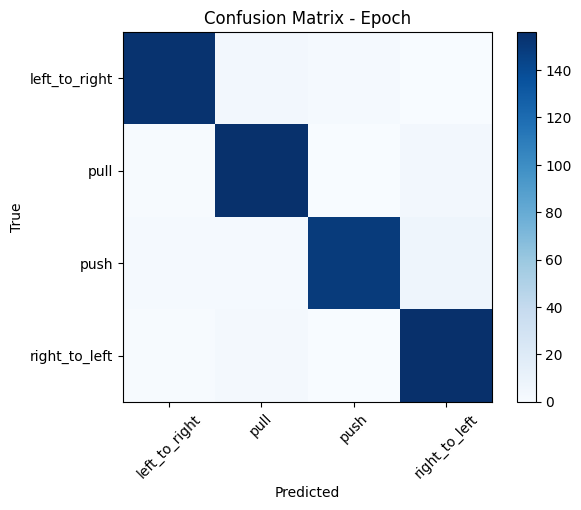

: 

In [15]:
matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure()
plt.imshow(matrix, cmap='Blues')
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)  # Set x-axis labels
plt.yticks(range(len(class_names)), class_names)  # Set y-axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Epoch')
#plt.savefig(os.path.join(confusion_matrices_dir, f'confusion_matrix_epoch_{i+1}.png'))
plt.show()